<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/tests/experiments/test_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# General imports

import os
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
!pip install torchmetrics
import torchmetrics as metrics
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [ ]:
# Custom Imports

COLAB = 'google.colab' in sys.modules
LOCAL = not COLAB

if COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/
    %cd ./visiope/
    !git checkout tests
    !git branch
    %cd ../

    # Get the root directory of the Git project
    root_dir = '/content/visiope'

    # Add custom modules to path
    custom_modules_path = root_dir + '/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsImporter, Ai4MarsSplitter, Ai4MarsDataLoader

# Import Loss
from loss.loss import Ai4MarsCrossEntropy, Ai4MarsDiceLoss

# Import Trainer
from trainer.trainer import Ai4MarsTrainer

# Import Tester
from tester.tester import Ai4MarsTester

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Set LOAD_CUNK to True and run this cell multiple times to load different chunk of the dataset
# Attention: you have to rerun this chell to load new data
LOAD_CHUNK = False

if LOAD_CHUNK:

    # Check if the variable has been defined
    if 'current_chunk' not in globals():
        current_chunk  = 0

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1BhL0nLbQt930l_ISDgUS8ZJRWGjH4eUU?usp=sharing'

            !gdown --folder {url} -O /content/

            load_data = '/content/chunk-dataset/'

    elif LOCAL:
        load_data = root_dir + '/datasetup/chunk-dataset/'


    # update current chunk
    current_chunk += 1000

    if current_chunk > 10000: raise Exception('Chunk out of range')

    print(f"Loading cunck {current_chunk//1000}")

    X, y = torch.load(load_data + 'dataset_' + str(current_chunk) + '.pt')

    # Build dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1])

    # Load dataset info
    if current_chunk <= 10000:
        load_info = './.info.pt'
        info = torch.load(load_info)

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader(
        [train_set, test_set, val_set], [32, 16, 16])

In [6]:
# Dataloader

# Set this to True if you wnat to load directly the dataloader
# this can be done only on colab and it is useful to avoid runtime crash
LOAD = False

if LOAD and not LOAD_CHUNK:

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/104YvO3LcU76euuVe-_62eS_Rld-tOZeh?usp=drive_link'

            !gdown --folder {url} -O /content/

            load_data = '/content/dataset/dataset1000.pt'

    elif LOCAL:
        load_data = root_dir + '/datasetup/dataset/dataset1000.pt'

    X, y = torch.load(load_data)

    # Build dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1])

    # Load dataset info
    load_info = './.info.pt'
    info = torch.load(load_info)

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader(
        [train_set, test_set, val_set], [32, 16, 16])


elif not LOAD and not LOAD_CHUNK:

    # Insert here your local path to the dataset (temporary)
    #data_path ='/home/leeoos/Desktop/' #input("Path to Dataset: ")
    data_path ='/content/' #input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = 500 #int(input("Number of images (max 1000): "))

    save_path = None
    # Uncomment the following line to the dataset on a local path
    #save_path = root_dir + '/datasetup/dataset/'

    if num_images > 1000 : raise Exception("Trying to import too many images")

    # Import data as Ai4MarsDataset
    # Ai4MarsDownload()(PATH=data_path)
    # importer = Ai4MarsImporter()
    # X, y, _ = importer(PATH=data_path, NUM_IMAGES=num_images, SAVE_PATH=save_path, SIZE=128)

    transform = None
    # Uncomment the following lines to apply transformations to the dataset
    '''
    transform = transforms.RandomChoice([
     transforms.RandomRotation(90)])
    '''


    # Split the dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1], transform=transform,
                                            SAVE_PATH=save_path)
    # Load info
    load_info = './.info.pt'
    info = torch.load(load_info)

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader([train_set, test_set, val_set], [32, 16, 16],
                                                   SAVE_PATH=save_path)

else:
    print("Nothing to do")
    pass

Splitting parameters: 
             Dataset: ai4mars-dataset-merged-0.1 
             Colab environment: True 
             Split percentages: [0.7, 0.2, 0.1] 
             Transformation: None 
             Svaving path: None 
             New image size: 128
Do you want to perform a lighter processing for the data? NO
Extrapolation of random inices ...
Splitting in progress ...
Done 

Building Dataloaders
Done 



Len of train set: 700
Len of test set: 200
Len of validation set: 100
image shape: torch.Size([128, 128, 3])


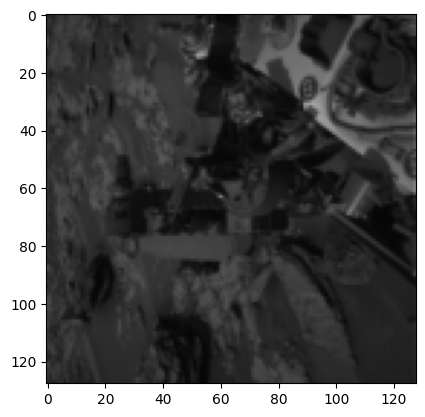

image shape: torch.Size([128, 128, 1])


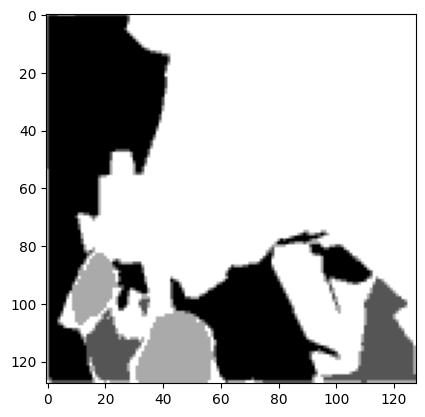

In [ ]:
# Just to check that different chunks contains different images
import matplotlib.pyplot as plt

print(f'Len of train set: {len(train_set)}')
print(f'Len of test set: {len(test_set)}')
print(f'Len of validation set: {len(val_set)}')

image, label = X[0], y[0]

print(f'image shape: {image.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()


In [7]:
# Clone remote repo with existing models

if COLAB:
    !git clone https://github.com/sithu31296/semantic-segmentation
    %cd semantic-segmentation
    %pip install -e .
    %pip install -U gdown

remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 21.50 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/semantic-segmentation
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=558d537b617682bab39a4f4c427c247f03203bb1a6a547f724f752a470457e9e
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5a

In [ ]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


In [8]:
#  Import segformer

from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B1',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth',
                                     map_location=device))
    print("Pretrained model's weights downloaded")
except:
    print("Download a pretrained model's weights from the result table.")

model.to(device)

print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [15]:
# Training parameters

loss_fn = Ai4MarsDiceLoss().to(device)
#loss_fn = Ai4MarsCrossEntropy().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
transform = transforms.RandomChoice([
     transforms.RandomRotation(90)])

trainer = Ai4MarsTrainer(loss_fn, optimizer, train_loader, val_loader,
                         transform=transform, device=device, info=info, model_name='MiT-B1', dump=True)

Data will be saved in /content/visiope/experiments/dump/20230717-194455-MiT-B1/hist/


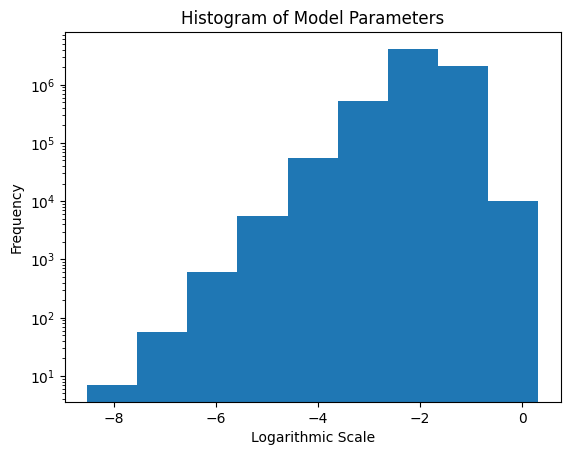

In [16]:
# Model Parameters
# Check if the variable has been defined
if 'run_once' not in globals():
    run_once = True
    trainer.param_hist(model, SAVE_PATH=root_dir+'/experiments', label='before')

In [17]:
# Start training
trainer.train_multiple_epoch(model, EPOCHS=5, SAVE_PATH=root_dir+'/experiments')

EPOCH 1
Train loss: 0.685091414234855
Transformed train loss: 0.04500658313433329
Time needed for training: 39.13713836669922 seconds
Validation loss: 0.6808014810085297 

EPOCH 2
Train loss: 0.6688075390729037
Transformed train loss: 0.04271935919920603
Time needed for training: 36.252535343170166 seconds
Validation loss: 0.6324739456176758 

EPOCH 3
Train loss: 0.6537601731040261
Transformed train loss: 0.05067816376686096
Time needed for training: 36.68876028060913 seconds
Validation loss: 0.6877384185791016 

EPOCH 4
Train loss: 0.6049706177277998
Transformed train loss: 0.04736261566480001
Time needed for training: 35.68530821800232 seconds
Validation loss: 0.690291553735733 

EPOCH 5
Train loss: 0.6012298464775085
Transformed train loss: 0.049555053313573204
Time needed for training: 36.82439613342285 seconds
Validation loss: 0.6037082970142365 



Data will be saved in /content/visiope/experiments/dump/20230717-194455-MiT-B1/loss/


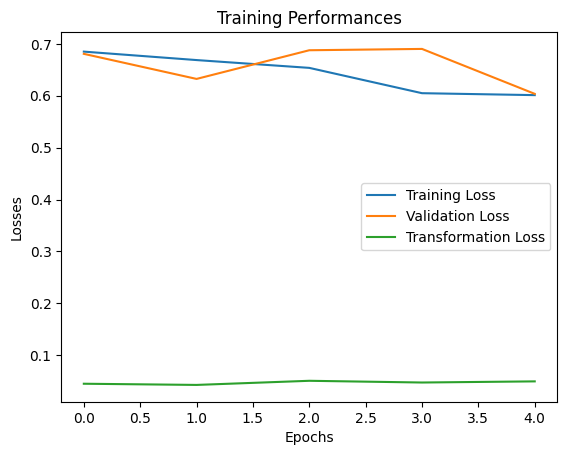

Train mean loss: 0.6427719181234186
Validation mean loss: 0.6590027391910553


In [18]:
# Plot loss

import matplotlib.pyplot as plt

trainer.plot_loss(model=model, SAVE_PATH=root_dir+'/experiments')

In [23]:
# Testing and evaluation Metrics

metric = metrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
tester = Ai4MarsTester(loss_fn, metric, test_loader, device=device)

In [24]:
# Start testing

tester.test_one_epoch(model)

Test loss: 0.542831037725721

Metrics MulticlassJaccardIndex(): 0.4000000059604645


Data will be saved in /content/visiope/experiments/dump/20230717-194455-MiT-B1/hist/


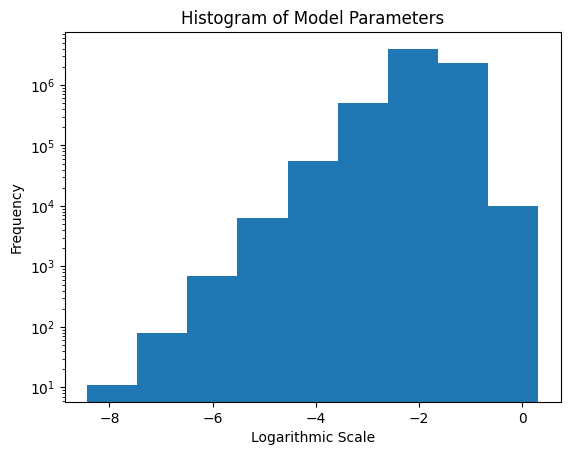

In [21]:
# Module Parameters
trainer.param_hist(model, SAVE_PATH=root_dir+'/experiments', label='after')

torch.Size([16, 3, 128, 128])


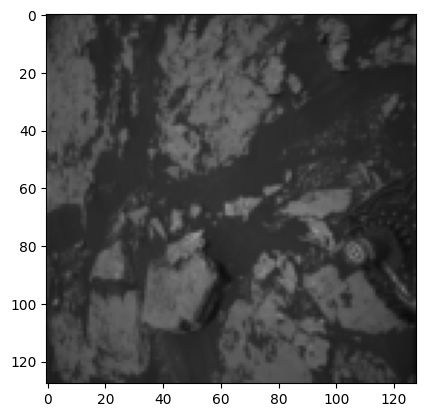

Data will be saved in /content/visiope/experiments/dump/20230717-194455-MiT-B1/images/


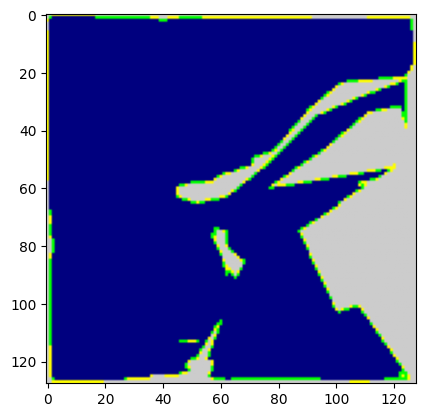

Data will be saved in /content/visiope/experiments/dump/20230717-194455-MiT-B1/images/


TypeError: ignored

<Figure size 640x480 with 0 Axes>

In [25]:
model.eval()

for i, batch in enumerate(test_loader):
  image, label = batch
  print(image.shape)
  pred = model(image.to(device))
  tester.show_images(image, trainer.results_path, index=i)
  tester.show_seg(label, trainer.results_path, index=i)
  tester.show_seg(pred.cpu(), trainer.results_path, index=i)